# Continuous Control


### Introduction

In this project we try to move a double-jointed arm to target locations with a reward of +0.1 for each step that the agent's hand is in the goal location.

![IMAGE ALT TEXT](reacher.gif)

The space consists of 33 variables corresponding to position, rotation, velocity and angular velocities of the arm. Every entry in the action vector should be a number between -1 and 1.

The goal of each agent is to keep its position at the target location for as many time steps as possible.

There are 2 versions of the environment, the first has 1 agent and the second has 20 agents. To solve the environment in the first version you must reach an average score of +30 while for the second version, the average score of the 20 agents must be +30 over 100 episodes.

### 1. Start the Environment

Installing necessary packages

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


Loading necessary packages

In [2]:
import torch
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent

from unityagents import UnityEnvironment

The environments corresponding to both versions of the environment are already saved and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Obtain information about the environment

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Behavior of untrained agent


In [6]:
env_info = env.reset(train_mode=False)[brain_name]     # Reset the environment    
states = env_info.vector_observations                  # Get the current state (for each agent)
scores = np.zeros(num_agents)                          # Initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # Select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # All actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # Send all actions to tne environment
    next_states = env_info.vector_observations         # Get next state (for each agent)
    rewards = env_info.rewards                         # Get reward (for each agent)
    dones = env_info.local_done                        # See if episode finished
    scores += env_info.rewards                         # Update the score (for each agent)
    states = next_states                               # Roll over states to next time step
    if np.any(dones):                                  # Exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.11399999745190144


### 4. Training the agent

The agent and model were based on the one's [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum) with slight changes for it to work with 20 agents.

Is important to note that the strategy was to implement an agent that takes 20 different actions which are passed to the environment as the action of 20 agents, those actions are saved one by one in the replay buffer and then sampled when there are enough experiences to learn (we used a threshold of 128 experiences to start learning).

##### Hyperparameters

To find the best hyperparameters we started to evaluate the behavior of learning with different batch sizes which proved to be an effective way to reach the goal.

| Buffer size | Batch size | Gamma |  Tau  | LR Actor | LR Critic | Max Avg Score |
|-------------|------------|-------|-------|----------|-----------|---------------|
|   10,000    |     128    |  0.99 | 0.001 |  0.0001  |   0.001   |     10.48     |
|   10,000    |     256    |  0.99 | 0.001 |  0.0001  |   0.001   |      9.92     |
|   10,000    |     512    |  0.99 | 0.001 |  0.0001  |   0.001   |     38.02     |

Is interesting to note that doubling the batch size gives worst performance, but quadrupling it results in a quite good performance. 

After repeating the exercise with a batch size of 512 we found that the learning process can be unstable depending on the initial conditions of the agent.


##### Actor model

In the case of the actor, we used 2 fully connected hidden layers with 128 and 64 units each and ReLU as activation function except for the output layer where we used a tanh activation function.

We had 33 inputs (state size) as input to the network and 4 (action size) as output neurons.

##### Critic model

For the critic, we used 2 fully connected hidden layers with 132 (128 + number of actions) and 64 units each and ReLU as activation function.

We had 33 inputs (state size) as input to the network and 1 neuron (for the Q value estiamtion) as output.

In [7]:
def ddpg(n_episodes = 250, max_t = 1000, print_every = 10):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]   # Reset the environment  
        states = env_info.vector_observations               # Get the current state
        scores_agents = np.zeros(num_agents)
        score = 0
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states)                               # Select an action
            env_info = env.step(actions)[brain_name]                  # Send the action to tne environment
            next_states = env_info.vector_observations                # Get the next state
            rewards = env_info.rewards                                # Get the reward    
            dones = env_info.local_done                               # See if episode has finished
            agent.step(states, actions, rewards, next_states, dones)  # Step and learning process
            scores_agents += rewards
            states = next_states
            if np.any(dones):
                break 
        score = np.mean(scores_agents)
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

Episode 10	Average Score: 0.88
Episode 20	Average Score: 3.08
Episode 30	Average Score: 8.65
Episode 40	Average Score: 11.44
Episode 50	Average Score: 14.66
Episode 60	Average Score: 18.01
Episode 70	Average Score: 24.50
Episode 80	Average Score: 26.73
Episode 90	Average Score: 27.15
Episode 100	Average Score: 28.47
Episode 110	Average Score: 32.46
Episode 120	Average Score: 34.79
Episode 130	Average Score: 36.02
Episode 140	Average Score: 36.37
Episode 150	Average Score: 36.67
Episode 160	Average Score: 36.38
Episode 170	Average Score: 36.44
Episode 180	Average Score: 36.58
Episode 190	Average Score: 37.16
Episode 200	Average Score: 36.71
Episode 210	Average Score: 36.45
Episode 220	Average Score: 37.65
Episode 230	Average Score: 37.69
Episode 240	Average Score: 38.02
Episode 250	Average Score: 37.28


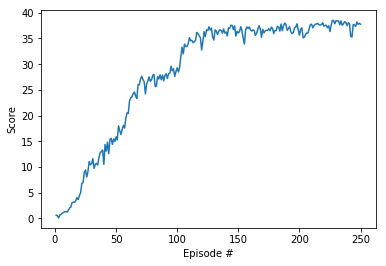

In [8]:
agent = Agent(state_size = state_size, action_size = action_size, random_seed = 17)
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

From the graph above, we can see that the average score of the agents is above +30 from episode 110 till the end which completes the 100 episodes

### 5. Behavior of trained agent

In [9]:
env_info = env.reset(train_mode=False)[brain_name]     # Reset the environment    
states = env_info.vector_observations                  # Get the current state (for each agent)
scores = np.zeros(num_agents)                          # Initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # Select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # Send all actions to tne environment
    next_states = env_info.vector_observations         # Get next state (for each agent)
    rewards = env_info.rewards                         # Get reward (for each agent)
    dones = env_info.local_done                        # See if episode finished
    scores += env_info.rewards                         # Update the score (for each agent)
    states = next_states                               # Roll over states to next time step
    if np.any(dones):                                  # Exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 38.42649914110079


In [10]:
env.close()

### 6. Ideas for future work

1. Use a different architecture for the actor and critic.
2. While a deeper network might slow the learning process, it might be possible to maintain it or improve it with a deeper network and more time steps between each round of training.